In [1]:
import os
import pandas as pd
import numpy as np
import time
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pydicom
from functools import partial
import gc

%matplotlib inline

In [2]:
#dcm形式
path = '/kaggle/input/rsna-2023-abdominal-trauma-detection'

train = pd.read_csv(path + '/' + 'train.csv')
train_series_meta = pd.read_csv(path + '/' + 'train_series_meta.csv') 

In [3]:
train_series_meta.head(2)

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0


In [4]:
patient_id_list = train_series_meta['patient_id'].unique()

In [5]:
temp = train_series_meta[['patient_id', 'aortic_hu']]

In [6]:
index_list = []
for patient_id in patient_id_list:
    temp_1 = temp[temp['patient_id'] == patient_id]['aortic_hu']
    zero_or_one = np.argmin(temp_1)
    index = temp_1.index[zero_or_one]
    index_list.append(index)

In [7]:
train_series_meta = train_series_meta.iloc[index_list, :]

In [8]:
df = pd.merge(train_series_meta, train,
              how='inner', on='patient_id')
df.head(2)

,patient_id,series_id,aortic_hu,incomplete_organ,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,21057,146.0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,18667,187.0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0


In [9]:
path = '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/'

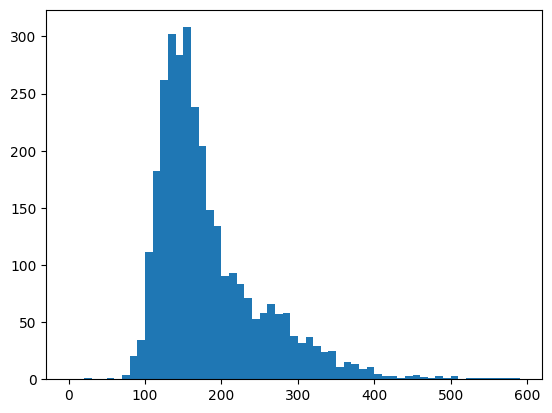

In [10]:
plt.hist(df['aortic_hu'], bins = [10 * i for i in np.arange(60)])
plt.show()

In [11]:
print(df['aortic_hu'].mean(), '+-', df['aortic_hu'].std())

183.61193199872895 +- 75.33458217789367


In [12]:
#dcm用
dir_path = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/'


train_image_path_list = []


time_sta = time.time()

for patient_id, series_id in zip(df['patient_id'], df['series_id']):
    sub_dir_path = dir_path + f'{patient_id}/{series_id}'
    list_object = os.listdir(sub_dir_path)
    list_1 = map(lambda x: int(x.split('.')[0]), list_object)
    list_2 = list(list_1)
    num = np.min(list_2) + (np.max(list_2) - np.min(list_2))/4
    image_path = sub_dir_path + f'/{int(num)}.dcm'
    train_image_path_list.append(image_path)
            



#dcm形式用
dicom_image_data_list = []
for image_path in train_image_path_list:
    image_dicom_data = pydicom.read_file(image_path)
    dicom_image_data_list.append(image_dicom_data.pixel_array)
    
    del image_dicom_data

dicom_image_arrays = []
index_list = []
index = 0
for image_array in dicom_image_data_list:
    if image_array.shape == (512, 512):
        dicom_image_arrays.append(image_array)
        index_list.append(index)
    index = index + 1
    

time_end = time.time()

tim = time_end - time_sta

print('Process Complete', '\n', 'PROCESSING TIME :', tim)

Process Complete 
 PROCESSING TIME : 342.32786989212036


In [13]:
df_copy = df.copy()
label_data = df_copy.iloc[index_list, :]
label_data.drop(['patient_id', 'series_id', 'aortic_hu', 'incomplete_organ', 'any_injury'], axis = 1, inplace = True)

/tmp/ipykernel_20/619525680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data.drop(['patient_id', 'series_id', 'aortic_hu', 'incomplete_organ', 'any_injury'], axis = 1, inplace = True)


In [14]:
def damage_reviser(organ):
    temp = label_data[[f'{organ}_healthy', f'{organ}_injury']]
    list_organ = [0 for _ in range(temp.shape[0])]
    for index in range(len(list_organ)):
        series = temp.iloc[index, :]
        if series[1] == 1:
            list_organ[index] = 1
        else:
            None
    return list_organ

def drop_damage_columns(organ):
    label_data.drop([f'{organ}_healthy', f'{organ}_injury'], axis = 1, inplace = True)

In [15]:
list_bowel = damage_reviser('bowel')
list_extravasation = damage_reviser('extravasation')

label_data['bowel'] = list_bowel
label_data['extravasation'] = list_extravasation

drop_damage_columns('bowel')
drop_damage_columns('extravasation')

/tmp/ipykernel_20/1340123651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data['bowel'] = list_bowel
/tmp/ipykernel_20/1340123651.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data['extravasation'] = list_extravasation
/tmp/ipykernel_20/3554152675.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [16]:
label_data.to_csv('label_data')
label_data.head(3)

,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,bowel,extravasation
0,0,1,0,1,0,0,0,0,1,0,1
1,1,0,0,1,0,0,1,0,0,0,0
2,1,0,0,1,0,0,1,0,0,0,0


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(dicom_image_arrays, label_data, test_size = 0.2, random_state = 89)

In [18]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]

y_train = np.array(y_train)
y_valid = np.array(y_valid)

y_train_1 = y_train[:, -1].reshape(-1, 1)
y_train_2 = y_train[:, -2].reshape(-1, 1)
y_train_3 = y_train[:, 0:3].reshape(-1, 3)
y_train_4 = y_train[:, 3:6].reshape(-1, 3)
y_train_5 = y_train[:, 6:9].reshape(-1, 3)

In [19]:
np.save('X_train', X_train)
np.save('X_valid', X_valid)
np.save('y_train', y_train)
np.save('y_valid', y_valid)

# Build Metrics

# Build Model

In [20]:
input = keras.layers.Input(shape=(X_train.shape[1:]))

conv_layer = partial(keras.layers.Conv2D, 
                     kernel_size = 3, activation = 'relu', padding = 'SAME')
dense_layer = partial(keras.layers.Dense,
                     activation = 'elu', kernel_initializer = 'he_normal')

# Encoder
conv1 = conv_layer(filters=32)(input)
conv2 = conv_layer(filters=32)(conv1)
pool1 = keras.layers.MaxPooling2D(2)(conv2)
dropout1 = keras.layers.Dropout(0.25)(pool1)

conv3 = conv_layer(filters=64)(dropout1)
conv4 = conv_layer(filters=64)(conv3)
pool2 = keras.layers.MaxPooling2D(2)(conv4)
dropout2 = keras.layers.Dropout(0.25)(pool2)

flat = keras.layers.Flatten()(dropout2)
dense = dense_layer(units=128)(flat)
bn = keras.layers.BatchNormalization()(dense)
dropout = keras.layers.Dropout(0.5)(bn)

# Output
output_bowel = keras.layers.Dense(1, activation='sigmoid', name='output_bowel')(dropout)
output_extravasation = keras.layers.Dense(1, activation='sigmoid', name='output_extravasation')(dropout)
output_kidney = keras.layers.Dense(3, activation='softmax', name='output_kidney')(dropout)
output_liver = keras.layers.Dense(3, activation='softmax', name='output_liver')(dropout)
output_spleen = keras.layers.Dense(3, activation='softmax', name='output_spleen')(dropout)

model = keras.models.Model(input, [output_bowel, output_extravasation, output_kidney, output_liver, output_spleen])

optimizer = keras.optimizers.Nadam(learning_rate=0.00014)
loss = {
    'output_bowel':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    'output_extravasation':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    'output_liver':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    'output_kidney':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    'output_spleen':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        }
model.compile(loss=loss, optimizer=optimizer)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [22]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model.h5', save_best_only = True)
run_index = 1
run_logdir = os.path.join(os.curdir, 'my_classifier',  "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

callbacks = [early_stopping_cb, tensorboard_cb, model_checkpoint_cb]

In [23]:
model.fit(X_train, 
          {'output_bowel':y_train_1,
           'output_extravasation':y_train_2,
           'output_kidney':y_train_3,
           'output_liver':y_train_4,
           'output_spleen':y_train_5},
          epochs = 1,
          callbacks = callbacks)

77/77 [==============================] - 2138s 28s/step - loss: 5.7827 - output_bowel_loss: 0.8350 - output_extravasation_loss: 0.8220 - output_kidney_loss: 1.4131 - output_liver_loss: 1.3771 - output_spleen_loss: 1.3354


In [24]:
model.save('Unet.keras')

In [25]:
model = keras.models.load_model('/kaggle/working/Unet.keras')

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

# Prediction

In [27]:
test_path = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'
num_list = os.listdir(test_path)
num_list = sorted(num_list)

test_image_path_list = []


for patient_id in num_list:
    test_dir_path = test_path + f'/{patient_id}'
    list_object = os.listdir(test_dir_path)
    list_object = sorted(list_object)
    for sub_dir_id in list_object:
        sub_dir_path = test_dir_path + f'/{sub_dir_id}'
        dicom_num_list = os.listdir(sub_dir_path)
        dicom_num_list = sorted(dicom_num_list)
        for dicom_id in dicom_num_list:
            image_path = sub_dir_path + f'/{dicom_id}'
            test_image_path_list.append(image_path)

In [28]:
import gc

dicom_image_test_list = []
for image_path in test_image_path_list:
    image_dicom_data = pydicom.read_file(image_path)
    array = image_dicom_data.pixel_array
    array = array[..., np.newaxis]
    if array.shape == (512, 512, 1):
        dicom_image_test_list.append(array)
    else:
        resized_array = tf.image.resize_with_pad(array, 512, 512, antialias=True)
        dicom_image_test_list.append(resized_array)

    # image_dicom_data と array のメモリ解放
    del image_dicom_data
    del array

    # ガベージコレクションの実行
    gc.collect()

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [30]:
test_image_path_list

['/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/48843/62825/30.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/50046/24574/30.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/63706/39279/30.dcm']

In [31]:
dicom_image_test_list = []
for image_path in test_image_path_list:
    image_dicom_data = pydicom.read_file(image_path)
    array = image_dicom_data.pixel_array
    array = array[..., np.newaxis]
    if array.shape == (512, 512, 1):
        dicom_image_test_list.append(array)
    else:
        resized_array = tf.image.resize_with_pad(array, 512, 512, antialias = True)
        dicom_image_test_list.append(resized_array)

X_test = np.array(dicom_image_test_list)

answer = model.predict(X_test)

1/1 [==============================] - 1s 808ms/step


In [32]:
submission =pd.DataFrame({})

submission['patient_id'] = num_list
submission['bowel_healthy'] = 1 - answer[0]
submission['bowel_injury'] = answer[0]
submission['extravasation_healthy'] = 1 - answer[1]
submission['extravasation_injury'] = answer[1]
submission[['kidney_healthy', 'kidney_low', 'kidney_high']] = answer[2]
submission[['liver_healthy', 'liver_low', 'liver_high']] = answer[3]
submission[['spleen_healthy', 'spleen_low', 'spleen_high']] = answer[4]

In [33]:
submission = pd.DataFrame(submission)

In [34]:
submission

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.573462,0.426538,0.475564,0.524436,0.198073,0.323877,0.478050,0.121606,0.342084,0.536310,0.303027,0.256580,0.440393
1,50046,0.674290,0.325710,0.453784,0.546216,0.186294,0.267800,0.545906,0.154463,0.301109,0.544428,0.298428,0.287569,0.414003
2,63706,0.595390,0.404610,0.453029,0.546971,0.194818,0.364310,0.440872,0.171080,0.319098,0.509823,0.303744,0.298359,0.397897


In [35]:
submission.to_csv('submission.csv', index = False)